In [190]:
# Instructions for submission

# 1. Rename this file to groupXX_PPGHR.ipynb where XX is your group number as visible in the Google spreadsheet
# 2. State the team members (e-mail, legi):
# example@student.ethz.ch, XX-YYY-ZZZ
# TO BE FILLED
# TO BE FILLED
# 3. Kaggle team name: TO BE FILLED
# 4. Upload this file in a zipped folder together with your final predictions to the provided Polybox link. See the Submission section in the PDF for more details.

In [273]:
# Import necessary libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter

In [274]:
sampling_rate = 128  # Hz

# Load data item containing the PPG, HR, and IMU signals from all phases
data = np.load('/kaggle/input/data-competition/mhealth24_data_public.npy', allow_pickle=True).item() # now it is a dict

print('Keys for data:', data.keys())

# Example to extract the data from phase 0
phase0_data = data['phase 0']
for i in range(0, 6):
    print('Keys for phase {}:'.format(i), data['phase {}'.format(i)].keys())
# Get the individual signals from phase 0
ppg_phase0 = phase0_data['PPG wrist']
ref_hr_phase0 = phase0_data['ground truth HR']  # only available for phase 0, 2, and 4 (training data)
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Z_phase0 = phase0_data['IMU Z wrist']

Keys for data: dict_keys(['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5'])
Keys for phase 0: dict_keys(['ground truth HR', 'PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])
Keys for phase 1: dict_keys(['PPG head', 'IMU X head', 'IMU Y head', 'IMU Z head'])
Keys for phase 2: dict_keys(['ground truth HR', 'PPG head', 'IMU X head', 'IMU Y head', 'IMU Z head'])
Keys for phase 3: dict_keys(['PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])
Keys for phase 4: dict_keys(['ground truth HR', 'PPG head', 'IMU X head', 'IMU Y head', 'IMU Z head'])
Keys for phase 5: dict_keys(['PPG head', 'IMU X head', 'IMU Y head', 'IMU Z head'])


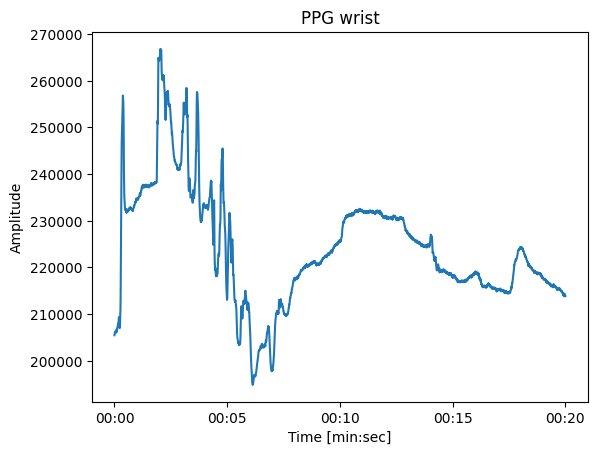

In [275]:
# Function to plot any signal with time on the x-axis
def plot_signal(signal, title, ylabel, sampling_rate=128, peaks=[]):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots()
    ax.plot(t if len(peaks) == 0 else np.linspace(0, len(signal), len(signal)) , signal)
    ax.set_title(title)
    ax.set_xlabel('Time [min:sec]' if len(peaks) == 0 else "Indexes")
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    
    # Plot peaks if given
    if len(peaks) != 0:
        plt.plot(peaks, signal[peaks], "x", color="green")
    plt.show()

# If you want to be able to interactively look at your plotted data (e.g., zooming in or out),
# uncomment the line with "%matplotlib widget" below
# Careful: This does not work on Kaggle, but requires that you run the Jupyter Notebook locally on your computer
# If you have an interactive plot and you want to go back to the non-interactive plot, comment the line with 
# "%matplotlib widget" out and restart your kernel
# If you accidently run this script on Kaggle when "%matplotlib widget" is not commented out and you receive an error afterwards that your plot cannot be plotted, comment "%matplotlib widget" out and restart the kernel via "Run << Factory reset"

# %matplotlib widget

# Example plot of a 10-second window of the PPG signal
plot_window_start = 200  # in seconds
plot_window_end = 220  # in seconds
plot_signal(ppg_phase0[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG wrist', 'Amplitude')

In [276]:
# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle
def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    signed_err = np.asarray(pred_hr) - np.asarray(ref_hr)
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))
    print("We tends to have a mean signed error of {}".format(np.mean(signed_err)))

# Example on how to use the print_score function with randomly generated HR values as the predictions
pred_hr_phase0 = list(np.random.randint(40, 180, len(ref_hr_phase0)))
print_score(pred_hr_phase0, ref_hr_phase0)

Mean error: 44.412, Median error 39.105
Resulting score 41.758
We tends to have a mean signed error of 34.71797236141324


In [277]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [279]:
# Clean low frequencies, RFFT since signals contain only real values (+faster)
def algo(ppg_phase, hr_gt=[], freq_min_hz=2/3, freq_max_hz=3, show=True):
    # Number samples
    N = len(ppg_phase)
    
    # Get magnitude
    ppg_mag = rfft(ppg_phase)
    # Get freq index
    ppg_freq = rfftfreq(N, 1 / sampling_rate)

    # Remove magnitude of freq out of given range
    ppg_mag = [mag if freq_min_hz <= freq <= freq_max_hz else 0 for mag,freq in zip(ppg_mag, ppg_freq)]
    
    # Get back signal
    #ppg_filt = irfft(ppg_mag)
    ppg_filt = butter_bandpass_filter(ppg_phase, freq_min_hz, freq_max_hz, sampling_rate)
    
    # Plot filered signal
    if show:
        plot_signal(ppg_phase[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG Full wrist Original', 'Amplitude')
        plot_signal(ppg_filt[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG Full wrist Cleaned', 'Amplitude')

    # Get peaks every 30 sec windows
    hr = []
    for i in range(0, N//sampling_rate, 30):
        hr_rt_filt = ppg_filt[i*sampling_rate:(i+ 30)*sampling_rate]
        # Normalize it
        hr_rt_filt = hr_rt_filt/np.max(hr_rt_filt)
        # Here you can modify freely the parameters of find peak
        # Minimum distance for our peaks is len_signal_per_minute/max_hrt_beat (30 seconds)
        distance = 2*len(hr_rt_filt)/180
        peaks, _ = find_peaks(hr_rt_filt, height = np.mean(hr_rt_filt), distance=distance)
        pred = 2*len(peaks)
        hr.append(pred)

        # Plot example in range
        if i == 30*30:
            hr_rt_orig = ppg_phase[i*sampling_rate:(i+ 30)*sampling_rate]
            # Normalize it
            hr_rt_orig = hr_rt_orig/np.max(hr_rt_orig)
            plot_signal(hr_rt_orig, 'PPG wrist Orig from {} to {} s'.format(i*sampling_rate, (i+ 30)*sampling_rate), 'Amplitude', peaks=peaks)
            plot_signal(hr_rt_filt, 'PPG wrist Filt from {} to {} s'.format(i*sampling_rate, (i+ 30)*sampling_rate), 'Amplitude', peaks=peaks)
            if len(hr_gt) != 0:         
                print("Prediction: {}, expected: {}".format(pred, hr_gt[i%30]))
            else:
                print("Prediction: {}".format(pred))

            
    # Print prediction of score if given heart rate ground truth
    if len(hr_gt) != 0:   
        print_score(hr, hr_gt)
    return np.arraY(hr)


# Basic Algo only PPG

In [207]:
# Clean low frequencies, RFFT since signals contain only real values (+faster)
def algo_max_freq_window(ppg_phase, hr_gt=[], freq_min_hz=2/3, freq_max_hz=3, show=True):
    # Number samples
    N = len(ppg_phase)
    
    # Get magnitude
    ppg_mag = rfft(ppg_phase)
    # Get freq index
    ppg_freq = rfftfreq(N, 1 / sampling_rate)

    # Remove magnitude of freq out of given range
    ppg_mag = [mag if freq_min_hz <= freq <= freq_max_hz else 0 for mag,freq in zip(ppg_mag, ppg_freq)]
    
    # Get back signal
    ppg_filt = irfft(ppg_mag)
    
    # Plot filered signal
    if show:
        plot_signal(ppg_phase[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG Full wrist Original', 'Amplitude')
        plot_signal(ppg_filt[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG Full wrist Cleaned', 'Amplitude')

    # Get peaks every 30 sec windows
    hr = []
    for i in range(0, N//sampling_rate, 30):
        # Normalize it
        # Get max spectral freq every second in the interval second
        freqs_window = []
        for k in range(0, 30):
            hr_rt_filt = ppg_filt[(i + k)*sampling_rate:(i + k + 1)*sampling_rate]
            hr_rt_filt = hr_rt_filt/np.max(hr_rt_filt)
            # Get magnitude
            mag = rfft(hr_rt_filt)
            # Get freq index
            freqs = rfftfreq(len(hr_rt_filt), 1 / sampling_rate)
            # Get max frequency
            freq = freqs[np.argmax(mag)]
            freqs_window.append(freq*60)
        
        # Correct outliers
        freqs_window = [freq if np.abs(freq - np.mean(freqs_window)) < 2*np.std(freqs_window) else np.mean(freqs_window) for freq in freqs_window]
        pred = np.mean(freqs_window)
        hr.append(pred)
            
    # Print prediction of score if given heart rate ground truth
    if len(hr_gt) != 0:   
        print_score(hr, hr_gt)
    return np.array(hr)


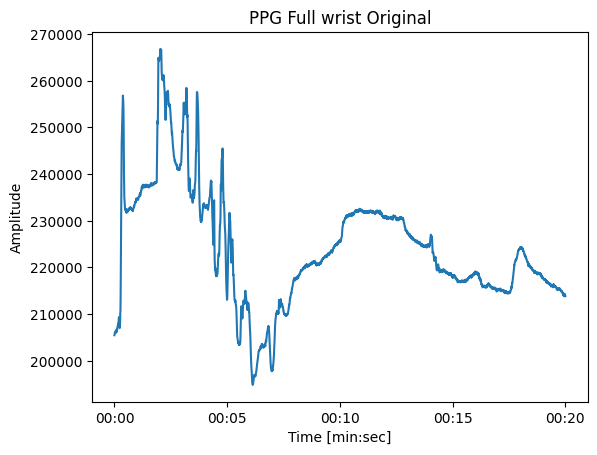

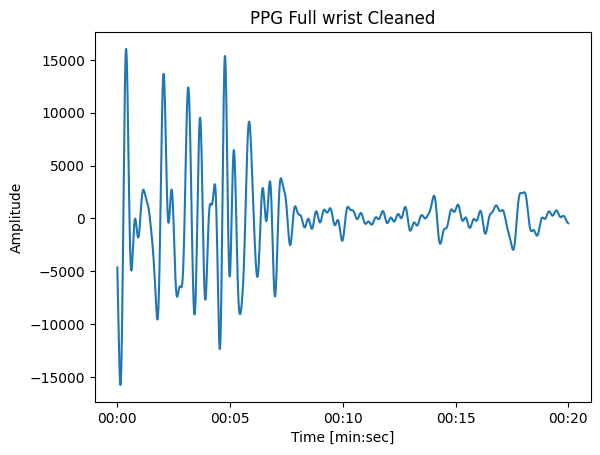

Mean error: 17.469, Median error 15.902
Resulting score 16.686
We tends to have a mean signed error of -3.5421286486877688


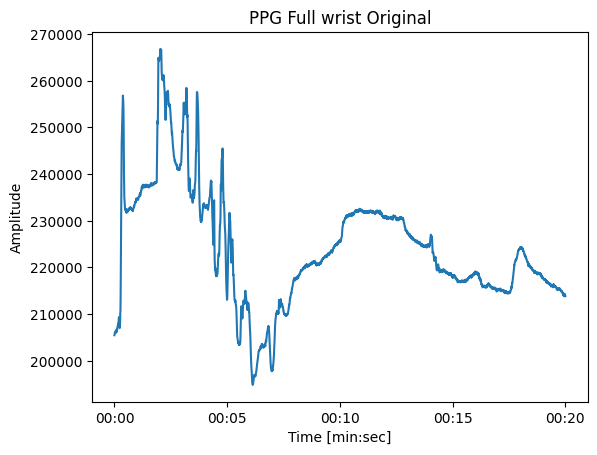

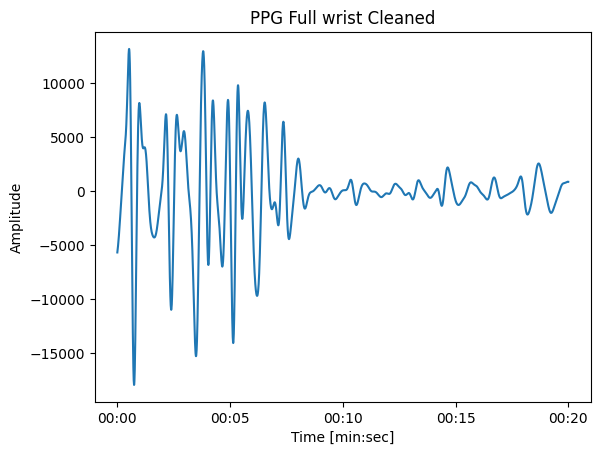

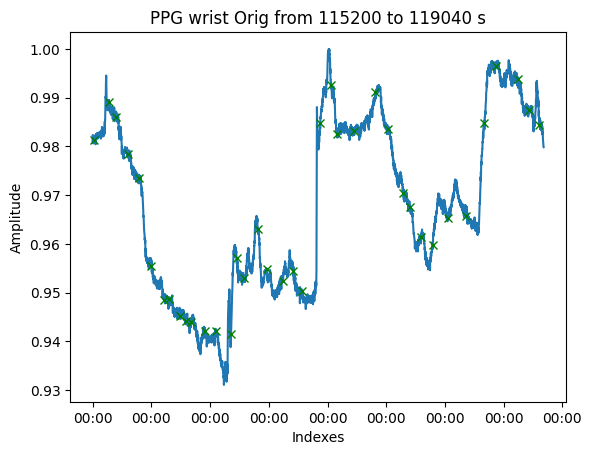

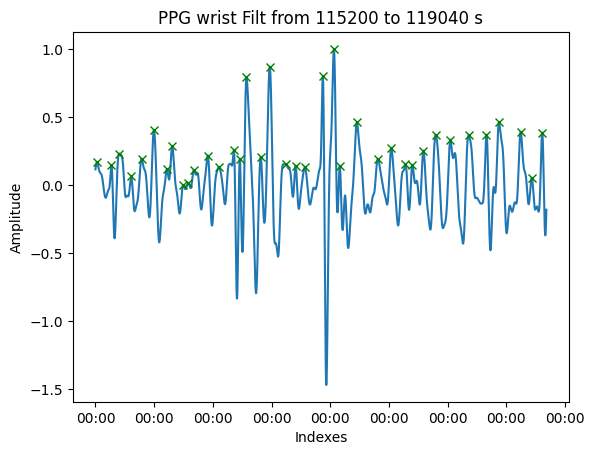

Prediction: 76, expected: 73.16168898043254
Mean error: 7.310, Median error 5.615
Resulting score 6.462
We tends to have a mean signed error of 1.2028208462617258


TypeError: can't multiply sequence by non-int of type 'float'

In [280]:
print_score(0.1*algo_max_freq_window(ppg_phase0, hr_gt=ref_hr_phase0) + 0.9*algo(ppg_phase0, hr_gt=ref_hr_phase0), ref_hr_phase0)
print(ref_hr_phase0)

# Trying using accelometer

In [199]:
def plot_spectr(signal, freq_min_hz=2/3, freq_max_hz=3):
    # Number samples
    N = len(signal)
    
    # Get magnitude
    magns = rfft(signal)
    # Get freq index
    freq = rfftfreq(N, 1 / sampling_rate)
    
    
    # Remove magnitude of freq out of given range
    magns= [mag if freq_min_hz < freq < freq_max_hz else 0 for mag,freq in zip(magns, freq)]
    
    plt.plot(freq, np.abs(magns)/np.max(magns))
    plt.xlim(freq_min_hz, freq_max_hz)
    plt.show()

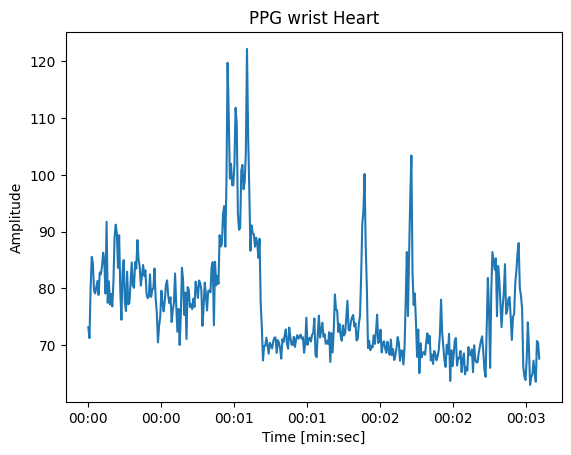

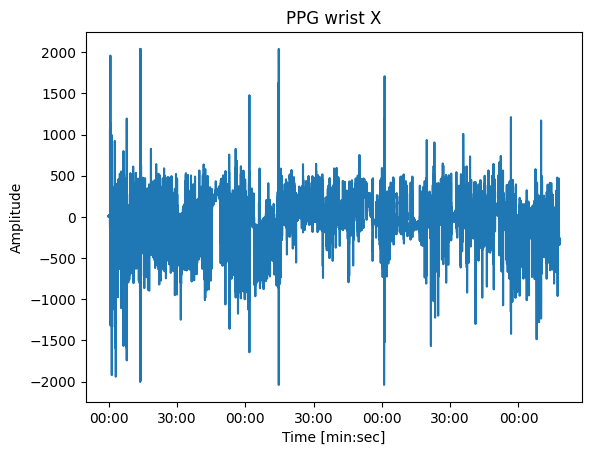

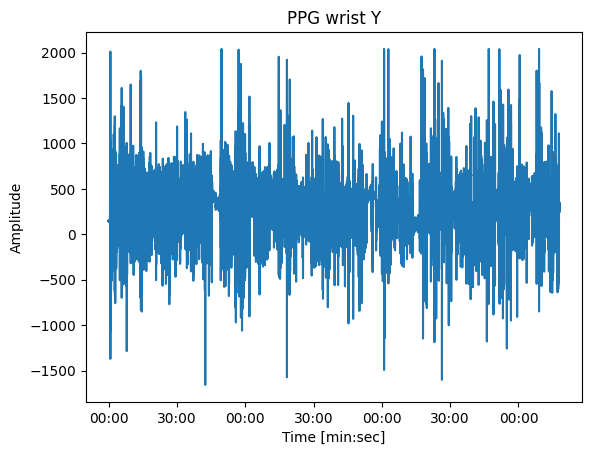

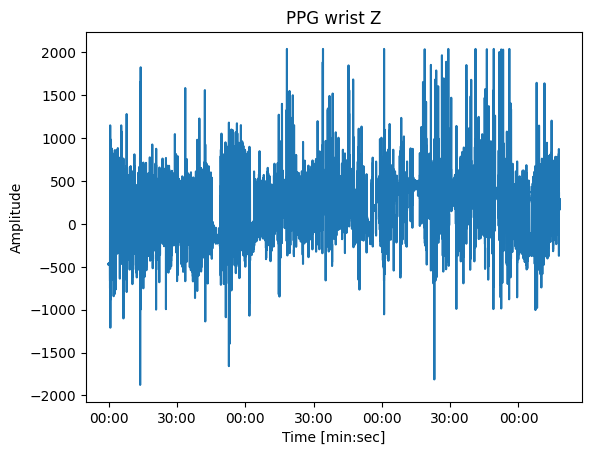

In [200]:
plot_signal(ref_hr_phase0, 'PPG wrist Heart', 'Amplitude')
plot_signal(IMU_X_phase0, 'PPG wrist X', 'Amplitude')
plot_signal(IMU_Y_phase0, 'PPG wrist Y', 'Amplitude')
plot_signal(IMU_Z_phase0, 'PPG wrist Z', 'Amplitude')

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


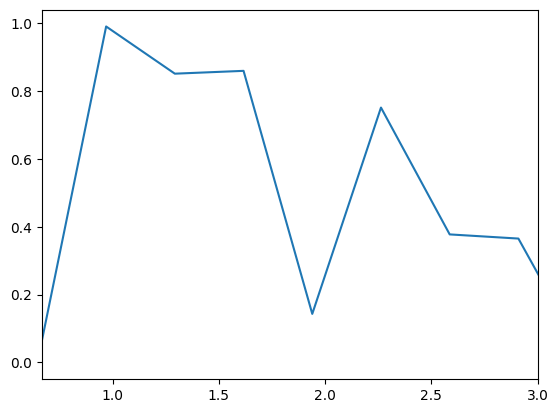

In [209]:
plot_spectr(ref_hr_phase0[0*sampling_rate:30*sampling_rate])

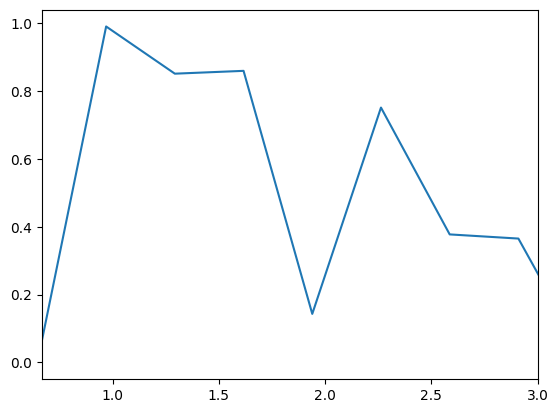

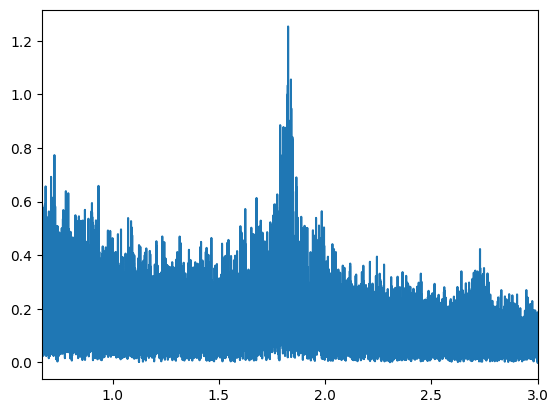

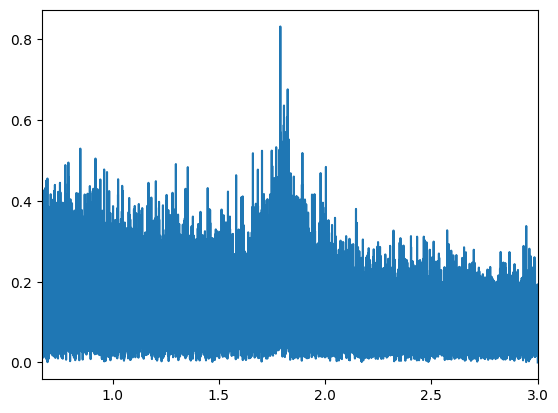

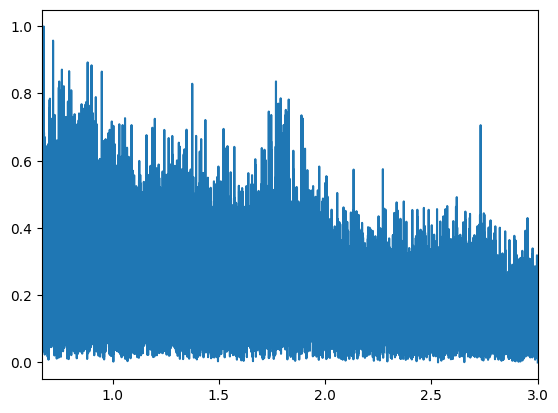

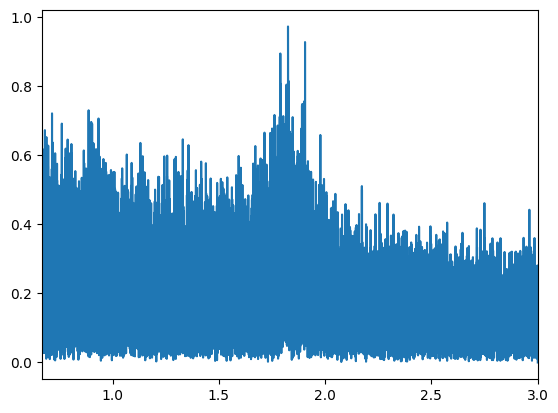

ValueError: operands could not be broadcast together with shapes (396,) (1520640,) 

In [202]:
plot_spectr(ref_hr_phase0)
plot_spectr(IMU_X_phase0)
plot_spectr(IMU_Y_phase0)
plot_spectr(IMU_Z_phase0)
plot_spectr(IMU_X_phase0+IMU_Y_phase0+IMU_Z_phase0)
plot_spectr(ref_hr_phase0-IMU_X_phase0+IMU_Y_phase0+IMU_Z_phase0)

In [ ]:
# Clean low frequencies, RFFT since signals contain only real values (+faster)
def algo_accel(ppg_phase, hr_gt=[], freq_min_hz=2/3, freq_max_hz=3, show=True):
    # Number samples
    N = len(ppg_phase)
    
    # Get magnitude
    ppg_mag = rfft(ppg_phase)
    # Get freq index
    ppg_freq = rfftfreq(N, 1 / sampling_rate)

    # Remove magnitude of freq out of given range
    ppg_mag = [mag if freq_min_hz <= freq <= freq_max_hz else 0 for mag,freq in zip(ppg_mag, ppg_freq)]
    
    # Get back signal
    ppg_filt = irfft(ppg_mag)
    
    # Plot filered signal
    if show:
        plot_signal(ppg_phase[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG Full wrist Original', 'Amplitude')
        plot_signal(ppg_filt[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG Full wrist Cleaned', 'Amplitude')

    # Get peaks every 30 sec windows
    hr = []
    for i in range(0, N//sampling_rate, 30):
        hr_rt_filt = ppg_filt[i*sampling_rate:(i+ 30)*sampling_rate]
        # Normalize it
        hr_rt_filt = hr_rt_filt/np.max(hr_rt_filt)
        # Here you can modify freely the parameters of find peak
        # Minimum distance for our peaks is len_signal_per_minute/max_hrt_beat (30 seconds)
        distance = 2*len(hr_rt_filt)/180
        peaks, _ = find_peaks(hr_rt_filt, height = np.mean(hr_rt_filt), distance=distance)
        pred = 2*len(peaks)
        hr.append(pred)

        # Plot example in range
        if i == 30*30:
            hr_rt_orig = ppg_phase[i*sampling_rate:(i+ 30)*sampling_rate]
            # Normalize it
            hr_rt_orig = hr_rt_orig/np.max(hr_rt_orig)
            plot_signal(hr_rt_orig, 'PPG wrist Orig from {} to {} s'.format(i*sampling_rate, (i+ 30)*sampling_rate), 'Amplitude', peaks=peaks)
            plot_signal(hr_rt_filt, 'PPG wrist Filt from {} to {} s'.format(i*sampling_rate, (i+ 30)*sampling_rate), 'Amplitude', peaks=peaks)
            if len(hr_gt) != 0:         
                print("Prediction: {}, expected: {}".format(pred, hr_gt[i%30]))
            else:
                print("Prediction: {}".format(pred))

            
    # Print prediction of score if given heart rate ground truth
    if len(hr_gt) != 0:   
        print_score(hr, hr_gt)
    return hr


In [ ]:
algo_accel(ppg_phase0, hr_gt=ref_hr_phase0)
print(ref_hr_phase0)

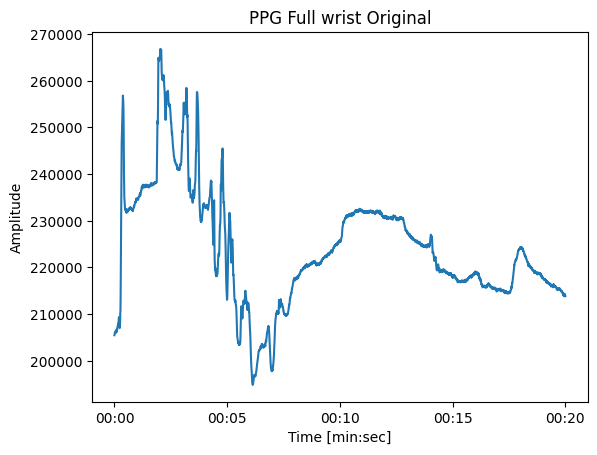

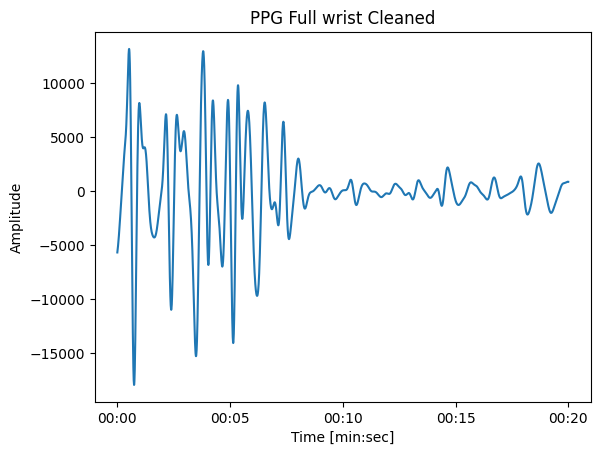

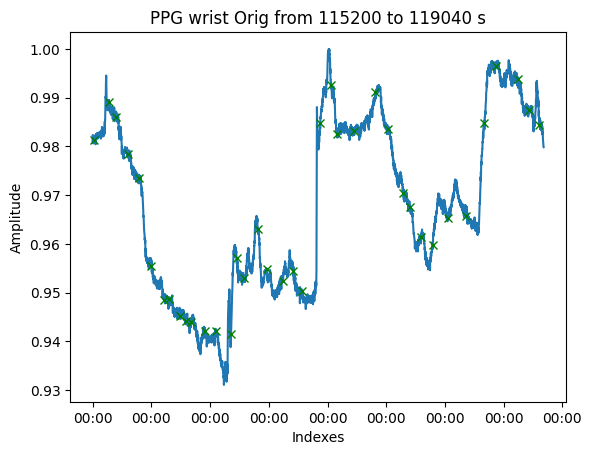

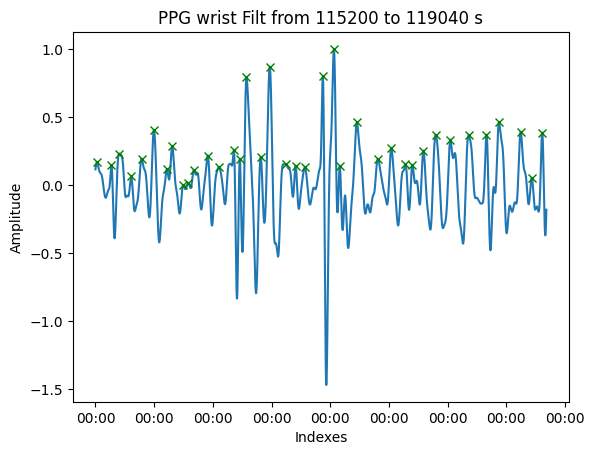

Prediction: 76, expected: 73.16168898043254
Mean error: 7.310, Median error 5.615
Resulting score 6.462
We tends to have a mean signed error of 1.2028208462617258


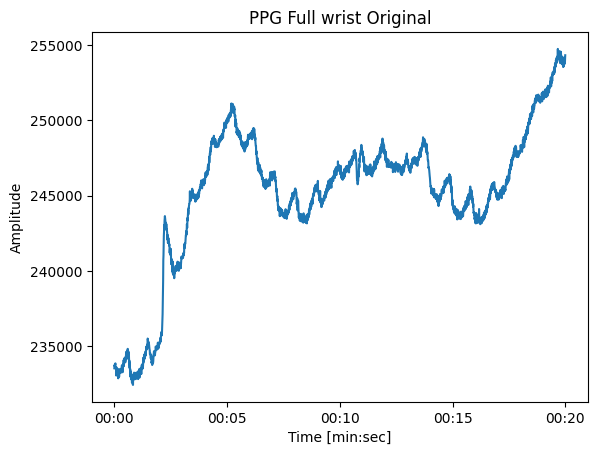

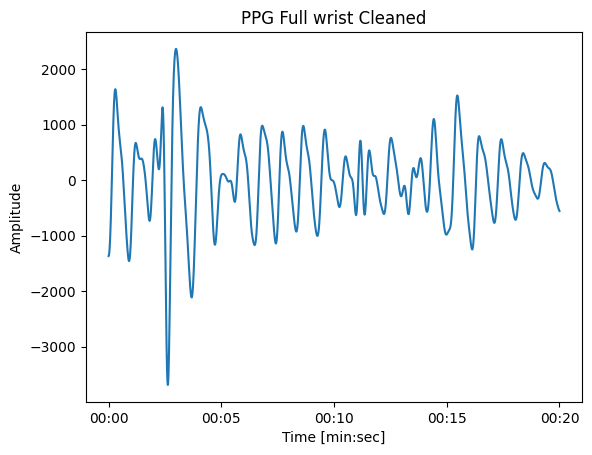

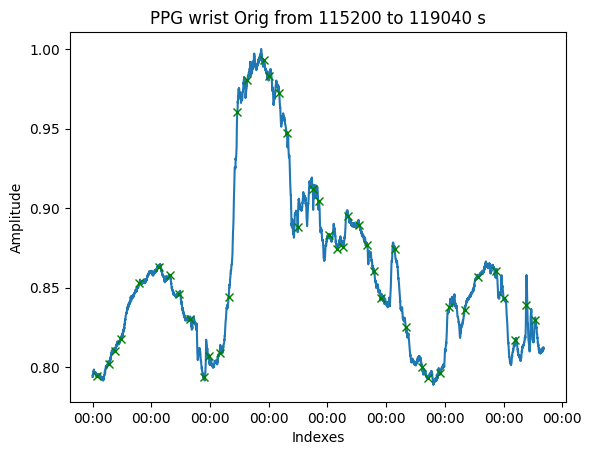

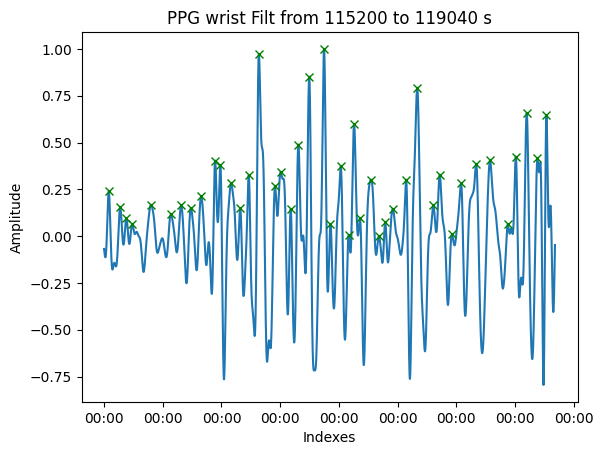

Prediction: 86


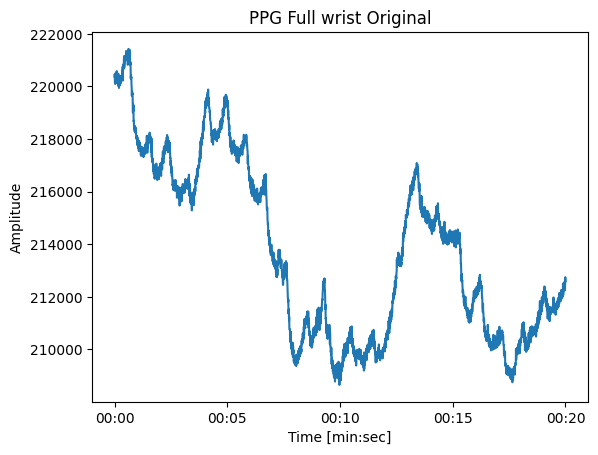

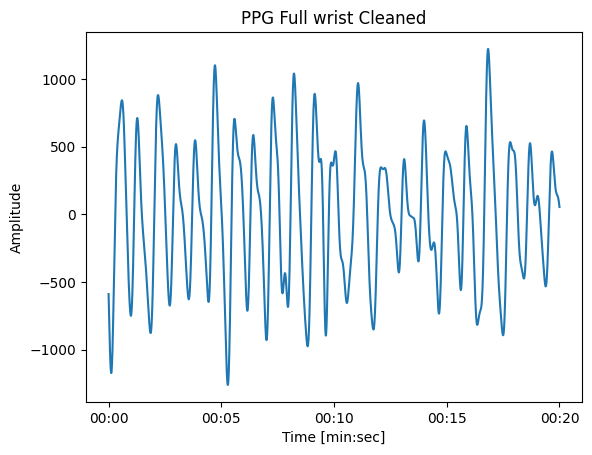

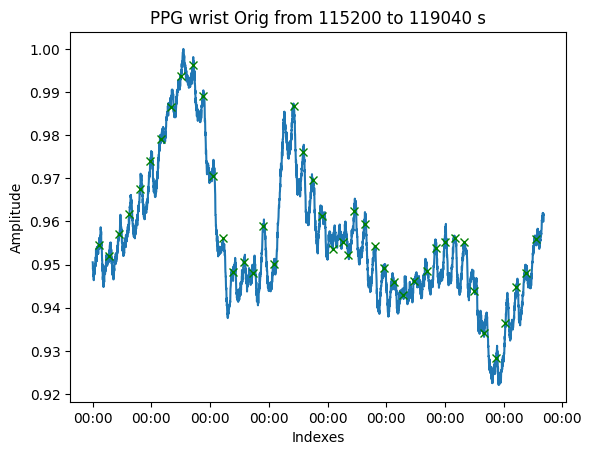

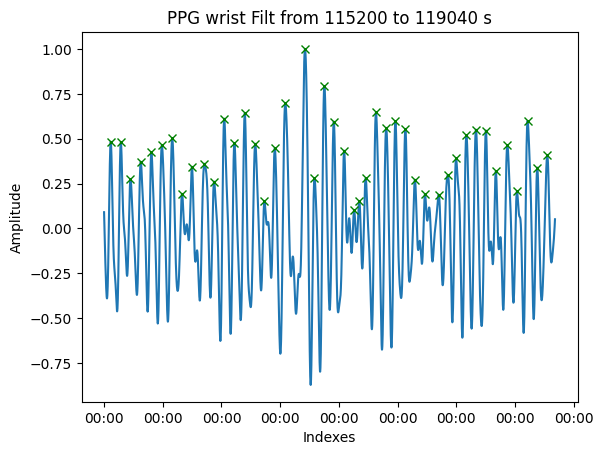

Prediction: 88, expected: 70.09126466753585
Mean error: 3.599, Median error 2.063
Resulting score 2.831
We tends to have a mean signed error of -1.189178863861545


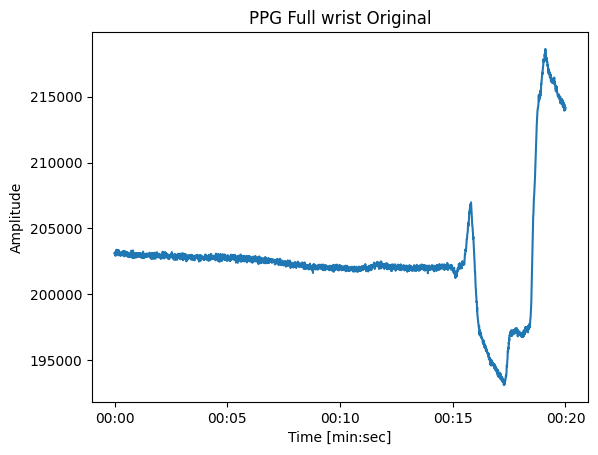

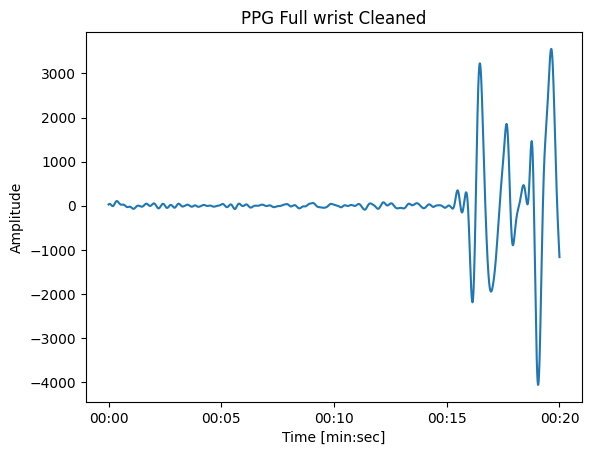

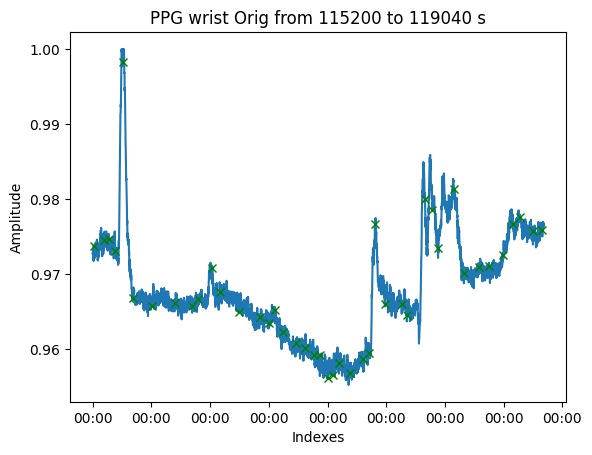

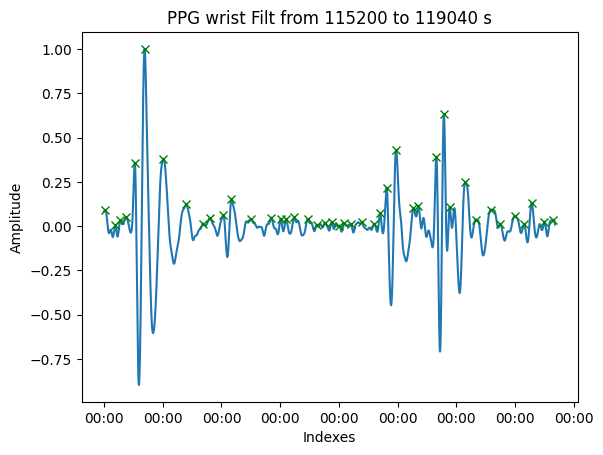

Prediction: 86


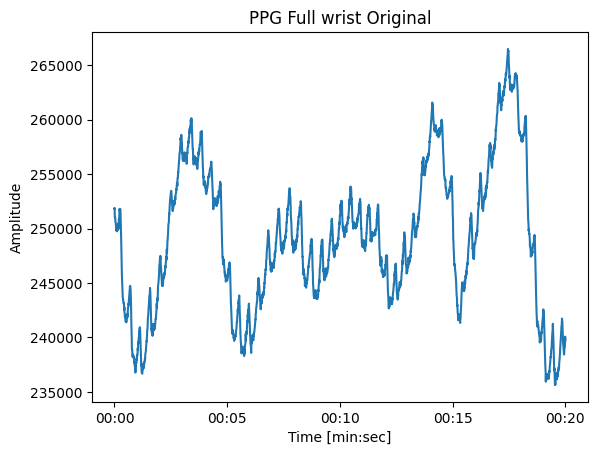

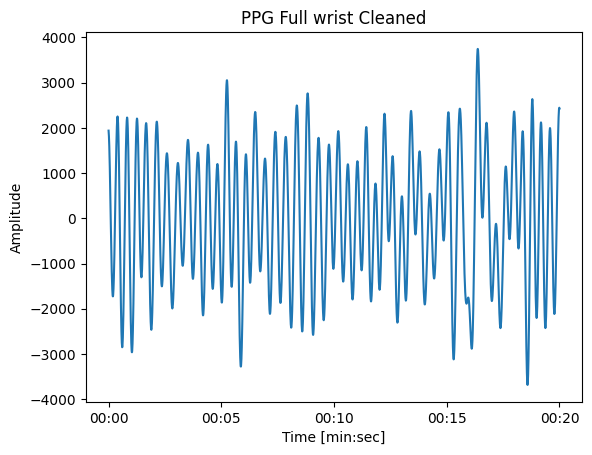

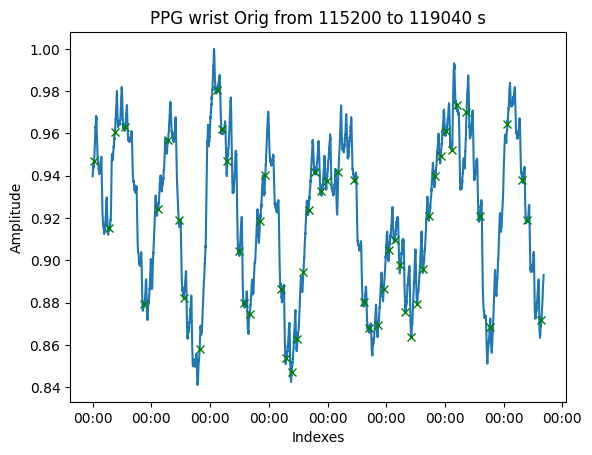

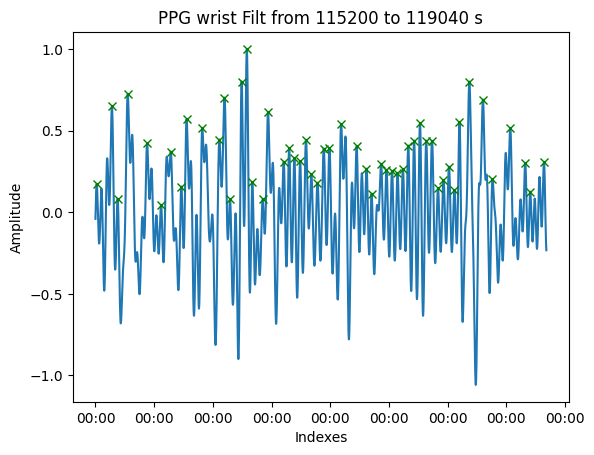

Prediction: 106, expected: 137.69520592438613
Mean error: 17.336, Median error 8.659
Resulting score 12.998
We tends to have a mean signed error of -17.065045265091214


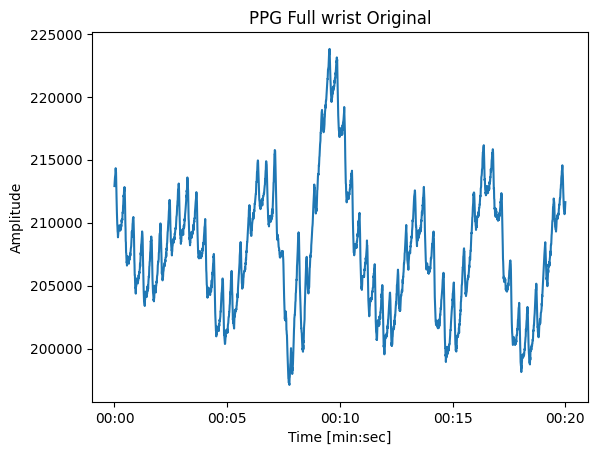

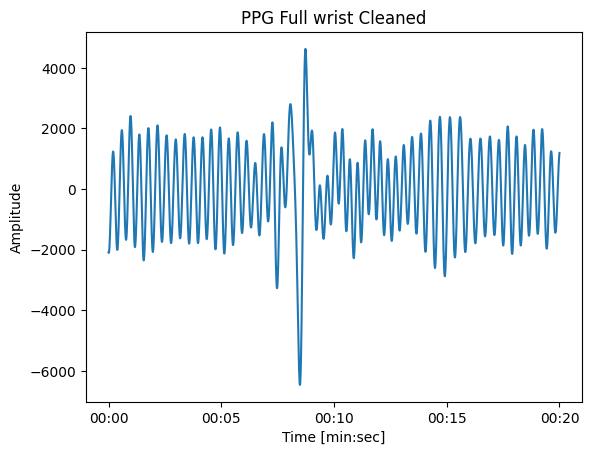

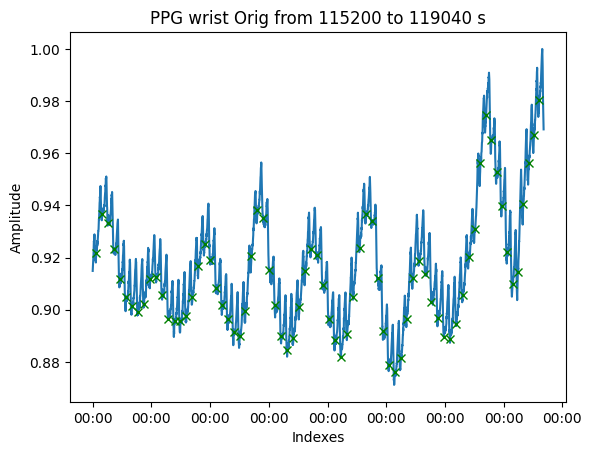

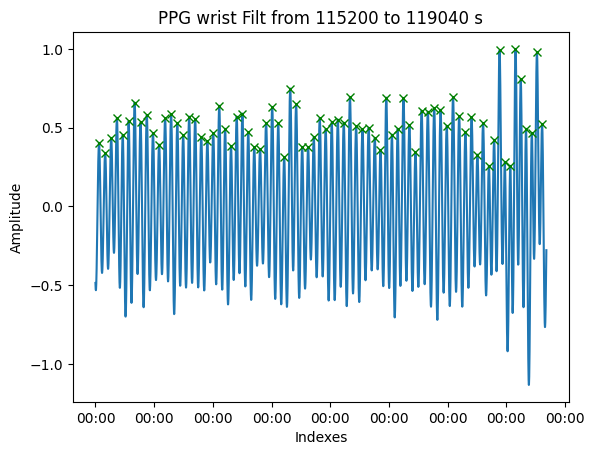

Prediction: 152


In [281]:
# For each phase, you should now have obtained a list of predicted HR values
# Below, we give an example of how you can produce the submission.csv file from your predicted HR values
# To demonstrate the format of the submission.csv file, we provide an example with randomly generated HR values
# For phase 0, 1, 2, and 3 you should each obtain 396 HR values
# For phase 4 and 5 you should each obtain 57 HR values
# IMPORTANT: You have to replace the following predicted HR values with your predicted HR values!
pred_hr_phase0 = algo(data['phase 0']['PPG wrist'], data['phase 0']['ground truth HR'])
pred_hr_phase1 = algo(data['phase 1']['PPG head'])
pred_hr_phase2 = algo(data['phase 2']['PPG head'], data['phase 2']['ground truth HR'])
pred_hr_phase3 = algo(data['phase 3']['PPG wrist'])
pred_hr_phase4 = algo(data['phase 4']['PPG head'], data['phase 4']['ground truth HR'])
pred_hr_phase5 = algo(data['phase 5']['PPG head'])

# You can keep the below code unchanged to produce the submission.csv file
pred_hr_phases = [pred_hr_phase0, pred_hr_phase1, pred_hr_phase2,
                  pred_hr_phase3, pred_hr_phase4, pred_hr_phase5]
ids = []
pred_hr_flattened = []

for phase_counter in range(len(pred_hr_phases)):
    for hr_counter in range(len(pred_hr_phases[phase_counter])):
        pred_hr_flattened.append(pred_hr_phases[phase_counter][hr_counter])
        ids.append(f'phase{phase_counter}_{hr_counter}')

# If you use Kaggle, on the right side in tab "Output", you should now see a file called "submission.csv" after pressing "refresh"
# Download the file and submit it to the competition on Kaggle to obtain a score on the leaderboard for your team
df = pd.DataFrame({'Id': ids, 'Predicted': pred_hr_flattened})
df.to_csv('/kaggle/working/submission.csv', index=False)